In [ ]:
import numpy as np
import h5py
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import tensorflow as tf
from tqdm.autonotebook import tqdm
from keras.utils import load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.nasnet import NASNetLarge, preprocess_input
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization

from keras.models import Model

import gc


def extract_zip(images_zip_path):
    # Extract the zip file
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/test')

def get_image_paths(dataset_path):
    image_paths = []
    # Iterate through the extracted images
    for root, _, files in os.walk(dataset_path):
        for file in files:
            filename = os.path.splitext(file)[0]
            image_paths.append(filename)
    return image_paths

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

def load_model(model_path):
    # Load the h5 model
    model = tf.keras.models.load_model(model_path)
    return model

#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features


def evaluate_model(model, X):
    # Perform model evaluation
    Y_pred = model.predict(X)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    return Y_pred_classes

def compute_metrics(Y_pred_classes, Y_true_classes):
    # Compute performance metrics
    # Assuming you have the ground truth labels available for comparison
    cm = confusion_matrix(Y_true_classes, Y_pred_classes)
    acc = accuracy_score(Y_true_classes, Y_pred_classes)
    precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
    recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
    f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')
    return cm, acc, precision, recall, f1

def plot_confusion_matrix(cm, classes):
    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def load_true_labels(csv_path, image_paths):
    # Load the true labels from the CSV file
    labels_df = pd.read_csv(csv_path)
    label_mapping = {}

    # Create a mapping of filename to true label
    for index, row in labels_df.iterrows():
        filename = row['id']
        breed = row['breed']
        label_mapping[filename] = breed

    # Extract true labels for the given image paths
    Y_true = []
    for image_path in image_paths:
        filename = os.path.basename(image_path)
        label = label_mapping[filename]
        Y_true.append(label)

    return Y_true

# Specify the paths to the h5 model and zip file of images
model_path = '/content/model.h5'
images_zip_path = '/content/test.zip'
labels_csv_path = '/content/labels.csv'
dataset_path ='/content/test'

# Load the model
model = load_model(model_path)

# Specify the desired image size (e.g., 224x224)
img_size = (331,331,3)

# Load the images for testing
extract_zip(images_zip_path)
image_paths = get_image_paths(dataset_path)
test_data = images_to_array_test('/content/test/', img_size)

inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, test_data)
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, test_data)
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, test_data)

nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, test_data)

test_features = extact_features(test_data)






  0%|          | 0/300 [00:00<?, ?it/s]

Ouptut Data Size:  (300, 331, 331, 3)
10/10 [==============================] - 84s 8s/step
Feature maps shape:  (300, 2048)
10/10 [==============================] - 161s 15s/step
Feature maps shape:  (300, 2048)
10/10 [==============================] - 189s 18s/step
Feature maps shape:  (300, 1536)
10/10 [==============================] - 417s 41s/step
Feature maps shape:  (300, 4032)
10/10 [==============================] - 84s 8s/step
Feature maps shape:  (300, 2048)
10/10 [==============================] - 145s 14s/step
Feature maps shape:  (300, 2048)
10/10 [==============================] - 432s 41s/step
Feature maps shape:  (300, 4032)
10/10 [==============================] - 203s 20s/step
Feature maps shape:  (300, 1536)
Final feature maps shape (300, 9664)


10/10 [==============================] - 0s 8ms/step
['samoyed', 'blenheim_spaniel', 'kuvasz', 'bedlington_terrier', 'collie', 'miniature_poodle', 'pug', 'labrador_retriever', 'american_staffordshire_terrier', 'bull_mastiff', 'english_foxhound', 'kelpie', 'great_pyrenees', 'welsh_springer_spaniel', 'scottish_deerhound', 'welsh_springer_spaniel', 'leonberg', 'chow', 'italian_greyhound', 'dandie_dinmont', 'irish_setter', 'irish_wolfhound', 'affenpinscher', 'standard_schnauzer', 'german_shepherd', 'bouvier_des_flandres', 'sussex_spaniel', 'west_highland_white_terrier', 'bloodhound', 'cocker_spaniel', 'miniature_poodle', 'norwegian_elkhound', 'dandie_dinmont', 'old_english_sheepdog', 'eskimo_dog', 'scottish_deerhound', 'standard_schnauzer', 'pug', 'entlebucher', 'border_terrier', 'whippet', 'cardigan', 'bernese_mountain_dog', 'scottish_deerhound', 'rhodesian_ridgeback', 'sealyham_terrier', 'italian_greyhound', 'pug', 'rottweiler', 'collie', 'miniature_pinscher', 'shih-tzu', 'brittany_spani

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


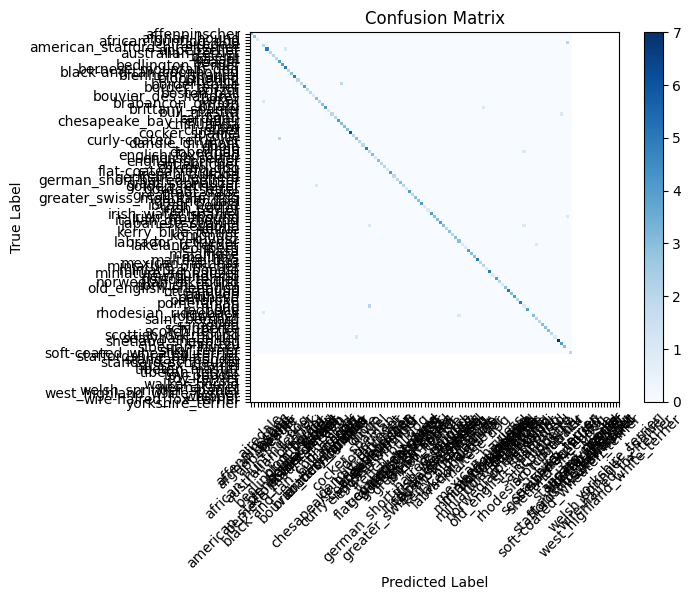

Accuracy: 0.93
Precision: 0.9465
Recall: 0.93
F1-Score: 0.9303333333333335


In [ ]:
import pandas as pd 
# Evaluate the model on the test images
Y_pred_classes = evaluate_model(model, test_features)

# Define class labels (replace with your own class labels)
classes = ['affenpinscher','afghan_hound','african_hunting_dog','airedale','american_staffordshire_terrier','appenzeller','australian_terrier','basenji','basset','beagle','bedlington_terrier','bernese_mountain_dog','black-and-tan_coonhound','blenheim_spaniel','bloodhound','bluetick','border_collie','border_terrier','borzoi','boston_bull','bouvier_des_flandres','boxer','brabancon_griffon','briard','brittany_spaniel','bull_mastiff','cairn','cardigan','chesapeake_bay_retriever','chihuahua','chow','clumber','cocker_spaniel','collie','curly-coated_retriever','dandie_dinmont','dhole','dingo','doberman','english_foxhound','english_setter','english_springer','entlebucher','eskimo_dog','flat-coated_retriever','french_bulldog','german_shepherd','german_short-haired_pointer','giant_schnauzer','golden_retriever','gordon_setter','great_dane','great_pyrenees','greater_swiss_mountain_dog','groenendael','ibizan_hound','irish_setter','irish_terrier','irish_water_spaniel','irish_wolfhound','italian_greyhound','japanese_spaniel','keeshond','kelpie','kerry_blue_terrier','komondor','kuvasz','labrador_retriever','lakeland_terrier','leonberg','lhasa','malamute','malinois','maltese_dog','mexican_hairless','miniature_pinscher','miniature_poodle','miniature_schnauzer','newfoundland','norfolk_terrier','norwegian_elkhound','norwich_terrier','old_english_sheepdog','otterhound','papillon','pekinese','pembroke','pomeranian','pug','redbone','rhodesian_ridgeback','rottweiler','saint_bernard','saluki','samoyed','schipperke','scotch_terrier','scottish_deerhound','sealyham_terrier','shetland_sheepdog','shih-tzu','siberian_husky','silky_terrier','soft-coated_wheaten_terrier','staffordshire_bullterrier','standard_poodle','standard_schnauzer','sussex_spaniel','tibetan_mastiff','tibetan_terrier','toy_poodle','toy_terrier','vizsla','walker_hound','weimaraner','welsh_springer_spaniel','west_highland_white_terrier','whippet','wire-haired_fox_terrier','yorkshire_terrier']

# Load the true labels for the images
Y_true_classes = load_true_labels(labels_csv_path, image_paths)
Y_pred_classes = [classes[label] for label in Y_pred_classes]

print (Y_pred_classes, Y_true_classes)
# Compute performance metrics
cm, acc, precision, recall, f1 = compute_metrics(Y_pred_classes, Y_true_classes)


# Plot confusion matrix
plot_confusion_matrix(cm, classes)

# Print performance metrics
print('Accuracy:', acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)